In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate,
    unconstrain_stationary_univariate)

from statsmodels.tsa.statespace import initialization

# Control variables

### Quarterly data

In [2]:
class NRI_Q(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, exog, lambda1=1/10):
        self.k_exog = 2
        exog = np.c_[exog]
                
        super(NRI_Q, self).__init__(endog, k_states=6, k_posdef=5, initialization='diffuse', exog=exog)
        self.ssm['design'] = np.array([[1,0,0,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0]])
        self.ssm['transition'] = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[1,1,1,0,0,0],
                                       [0,0,0,1,0,1],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        self.ssm['obs_cov'] = np.zeros((3,3))
        self.ssm['selection', :3, :3] = np.eye(3)
        self.ssm['selection', 4:, 3:] = np.eye(2)
        self.ssm['state_cov'] = np.eye(5)
        self.ssm['state_intercept'] = np.zeros((self.k_states, self.nobs))
#         init = initialization.Initialization(self.k_states)
#         init.set((0, 3), 'stationary')
#         init.set((3, 6), 'diffuse')
#         self.ssm.initialize(init)
        
        self.positive_parameters = slice(7, 10)
        self.stationary_parameters = [0, 2, 6]
        self.lambda1 = lambda1
        self.lambda2 = 1/100
        
    def clone(self, endog, exog=None, **kwargs):
        return self._clone_from_init_kwds(endog, exog=exog, **kwargs)
        
    @property
    def param_names(self):
        return ['a_pp','a_py','b_yy','b_yr','c_rp','c_ry','c_rr',
                's_p','s_y','s_r','d_po','d_yo','d_pc','d_yc']

    @property
    def start_params(self):
        params = np.r_[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
                       10, 10, 10, -0.1, -0.1, -0.1, -0.1]
        return params
        
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.stationary_parameters] = constrain_stationary_univariate(unconstrained[self.stationary_parameters])
        constrained[self.positive_parameters] = unconstrained[self.positive_parameters]**2
        return constrained
    
    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.stationary_parameters] = unconstrain_stationary_univariate(constrained[self.stationary_parameters])
        unconstrained[self.positive_parameters] = constrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)
        self['transition', 0, :2] = params[:2]
        self['transition', 1, 1:3] = params[2:4]
        self['transition', 2, :3] = params[4:7]
        self['state_cov'] = np.diag([params[7]**2, params[8]**2, params[9]**2,
                                     self.lambda1*params[9]**2, self.lambda2*params[8]**2])
#         self['state_intercept'] = ([params[10],params[11],0,0,0,0] * self.exog).T
        self['state_intercept', 0, :] = params[10] * self.exog.T[0] + params[12] * self.exog.T[1]
        self['state_intercept', 1, :] = params[11] * self.exog.T[0] + params[13] * self.exog.T[1]

In [3]:
data = pd.read_excel('python_quarter.xlsx')
data.index = data.date
data.drop('date', axis=1, inplace=True)

data['inf'] = (data.cpi_sa - 1) * 400
data['inf_lag'] = data.inf.shift(1)
data['inf_yoy'] = (data.cpi_yoy - 1) * 100

data['y'] = np.log(data.rgdp_sa)
data['dp'] = data.inf_yoy - data.target * 100
data['r'] = data.miacr - 0.5 * (data.target * 100 + data.inf_lag)
data['oil'] = np.log(data.brent).shift(1)
data['ex'] = np.log(data.usd).shift(1)
data['cr_to_gdp'] = np.log(data.credit_to_gdp).shift(1)

data.dropna(inplace=True, subset='miacr')
data

,rgdp,cpi,cpi_yoy,miacr,usd,brent,target,credit_to_gdp,cpi_sa,rgdp_sa,...,Unnamed: 17,inf,inf_lag,inf_yoy,y,dp,r,oil,ex,cr_to_gdp
date,,,,,,,,,,,,,,,,,,,,,
2000-07-01,12992.152302,1.041443,1.185434,13.285000,27.792424,30.404531,0.18,22.5,1.055939,12324.585457,...,2000Q3,22.375660,19.164390,18.543409,9.419351,0.543409,-5.297195,3.296602,3.345800,3.100092
2000-10-01,13110.103184,1.053621,1.202002,12.676667,27.885556,30.100476,0.18,23.7,1.054318,12505.082577,...,2000Q4,21.727001,22.375660,20.200244,9.433890,2.200244,-7.511163,3.414592,3.324763,3.113515
2001-01-01,11605.255814,1.070578,1.236679,14.123333,28.553607,26.265937,0.13,22.3,1.058160,12622.076882,...,2001Q1,23.263938,21.727001,23.667874,9.443203,10.667874,-3.240167,3.404541,3.328109,3.165475
2001-04-01,12345.919168,1.052802,1.236760,15.903333,28.996721,27.654262,0.13,23.3,1.049643,12769.711262,...,2001Q2,19.857354,23.263938,23.676003,9.454831,10.676003,-2.228636,3.268273,3.351783,3.104587
2001-07-01,13775.481404,1.010628,1.200165,14.043333,29.332308,25.688750,0.13,24.7,1.027176,12947.772934,...,2001Q3,10.870506,19.857354,20.016547,9.468679,7.016547,-2.385343,3.319780,3.367183,3.148453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,22403.882578,1.020234,1.065115,5.723333,74.293576,69.083906,0.04,107.1,1.019992,23713.672676,...,2021Q2,7.996834,6.986449,6.511526,10.073807,2.511526,0.230109,4.116119,4.309033,4.717606
2021-07-01,23935.957483,1.010834,1.074081,7.146667,73.470935,73.227879,0.04,105.0,1.020383,23577.102181,...,2021Q3,8.153197,7.996834,7.408086,10.068031,3.408086,1.148250,4.235322,4.308024,4.673763
2021-10-01,26426.353897,1.029177,1.083930,8.046667,72.654305,79.664394,0.04,102.0,1.023702,23441.972983,...,2021Q4,9.480745,8.153197,8.393015,10.062283,4.393015,1.970068,4.293576,4.296890,4.653960


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


{'fopt': 2.3289718893078972, 'gopt': array([ 1.32449948e-01, -1.31460499e-02,  5.87748028e-02,  5.06606724e+00,
       -2.16789585e-02,  3.57196095e-04, -9.33530123e-02,  1.10472916e-01,
       -1.23447982e+00, -8.82440126e-02, -2.01457038e-01, -2.83682015e-01,
       -1.82188502e-01, -1.76599136e-01]), 'fcalls': 1155, 'warnflag': 1, 'converged': False, 'iterations': 50}


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       ['dp', 'y', 'r']   No. Observations:                   88
Model:                          NRI_Q   Log Likelihood                -204.950
Date:                Wed, 31 May 2023   AIC                            449.899
Time:                        00:56:18   BIC                            499.446
Sample:                    07-01-2000   HQIC                           469.860
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_pp           0.6841      0.089      7.692      0.000       0.510       0.858
a_py          -0.1549      0.131     -1.183      0.237      -0.412       0.102
b_yy          -0.0259      0.161     -0.161      0.872      -0.342       0.290
b_yr          -0.0026      0.001     -3.686      0.000      -0.004      -0.001
c_rp           0.1498      0.078      1.919      0.055      -0.003       0.303
c_ry          -0.1362     26.982     -0.005      0.996     -53.020      52.747
c_rr           0.1456      0.107      1.364      0.172      -0.064       0.355
s_p            2.2143      0.144     15.366      0.000       1.932       2.497
s_y            0.0154      0.001     15.961      0.000       0.013       0.017
s_r            2.7373      0.193     14.192      0.000       2.359       3.115
d_po           0.1133      0.770      0.147      0.883      -1.395       1.622
d_yo           0.0353      0.011      3.303      0.001       0.014       0.056
d_pc           0.0712      0.774      0.092      0.927      -1.445       1.588
d_yc           0.0256      0.056      0.460      0.646      -0.083       0.135
======================================================================================
Ljung-Box (L1) (Q):     18.06, 31.24, 5.44   Jarque-Bera (JB):   153.54, 105.73, 68.09
Prob(Q):                  0.00, 0.00, 0.02   Prob(JB):                0.00, 0.00, 0.00
Heteroskedasticity (H):   1.09, 3.62, 0.95   Skew:                   1.84, -1.53, 1.03
Prob(H) (two-sided):      0.82, 0.00, 0.90   Kurtosis:                8.41, 7.49, 6.85
======================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

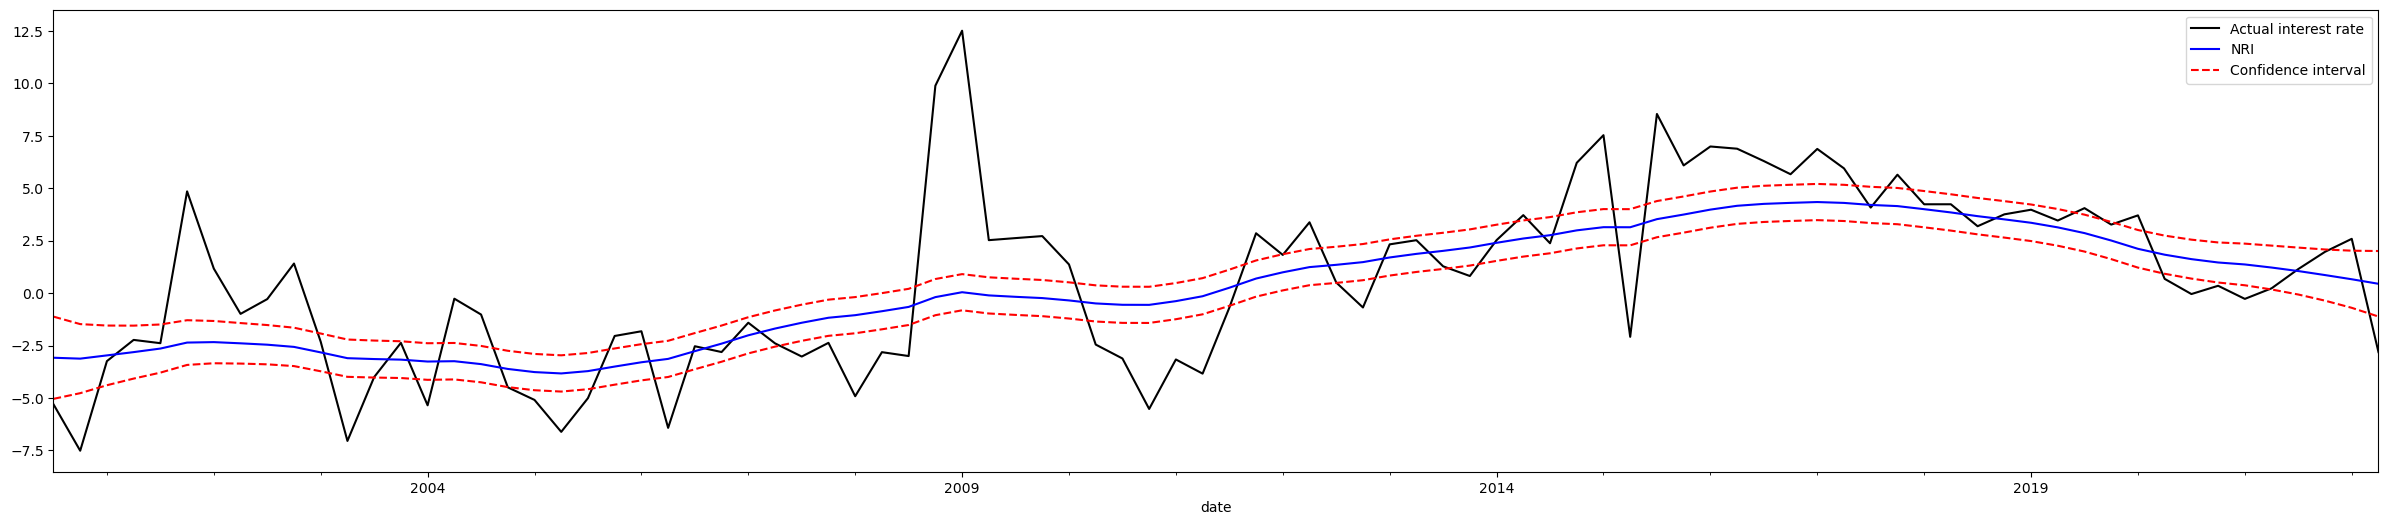

In [4]:
end = data[['dp','y','r']]
exog = data[['oil','cr_to_gdp']]

ggmodel = NRI_Q(end, exog, lambda1=1/25)
res = ggmodel.fit()
print(res.mle_retvals)

display(res.summary())

state_cov = res.states.smoothed_cov.reset_index(level=0)
conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

plt.figure(figsize=(30, 6))
end['r'].plot(color='black', label='Actual interest rate');
res.states.smoothed['state.4'].plot(color='blue', label='NRI');
(res.states.smoothed['state.4']+conf_int).plot(color='red', ls='--', label='Confidence interval');
(res.states.smoothed['state.4']-conf_int).plot(color='red', ls='--', label='_Confidence interval');
plt.legend();

idx = end.index

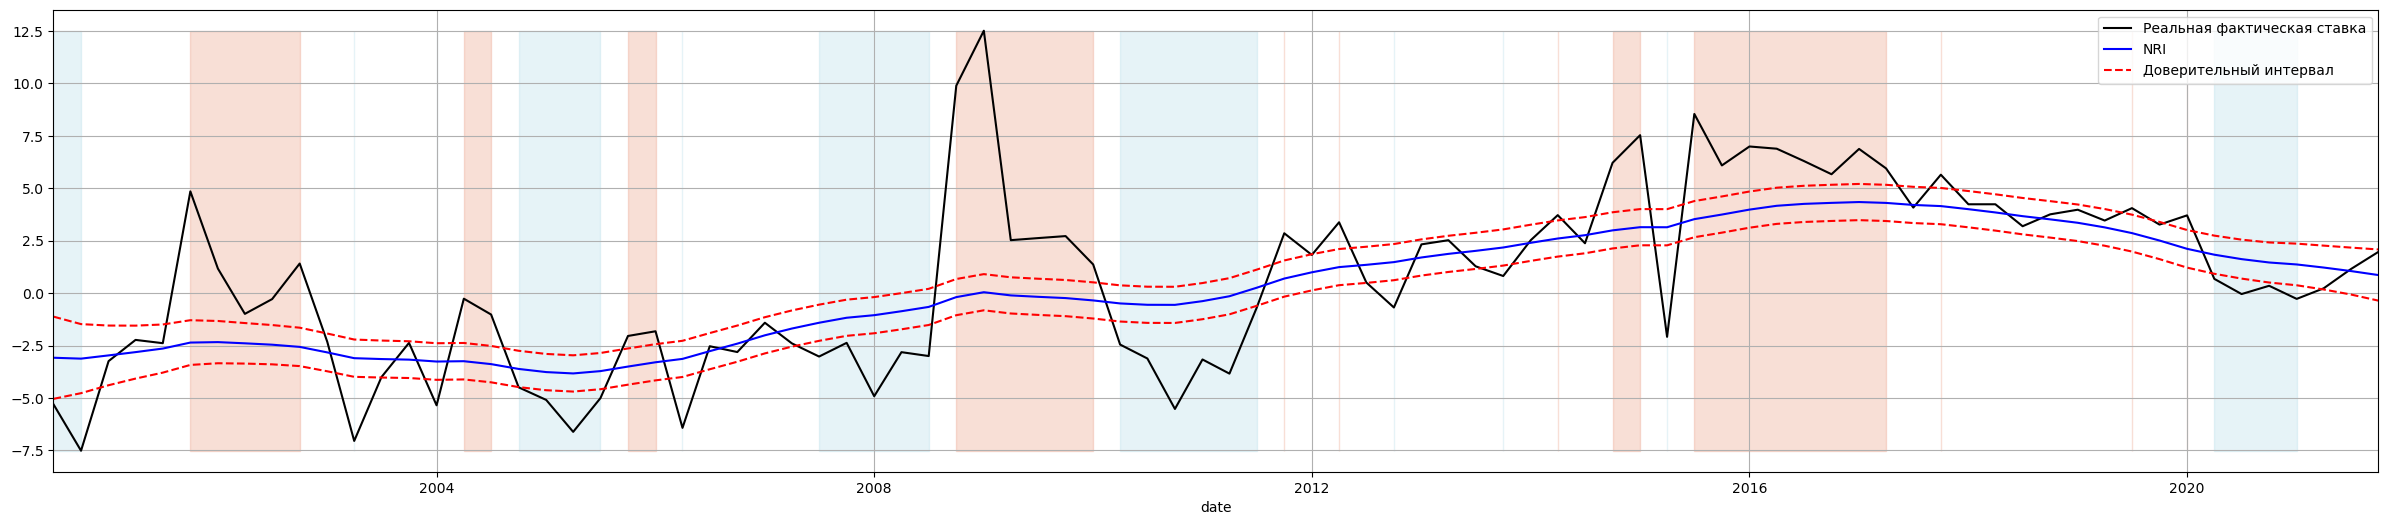

In [6]:
fig, ax = plt.subplots(figsize=(30, 6))
ax.plot(end['r'], color='black', label='Реальная фактическая ставка')
ax.set_xlim([pd.to_datetime('2000-07-01'), pd.to_datetime('2021-10-01')])
ax.plot(res.states.smoothed['state.4'], color='blue', label='NRI')
ax.plot(res.states.smoothed['state.4']+conf_int, color='red', ls='--', label='Доверительный интервал')
ax.plot(res.states.smoothed['state.4']-conf_int, color='red', ls='--', label='_Доверительный интервал')
ax.set(xlabel='date', ylabel='', title='')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']>res.states.smoothed['state.4']+conf_int.values), alpha=0.3, color='darksalmon')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']<res.states.smoothed['state.4']-conf_int.values), alpha=0.3, color='lightblue')
ax.grid();
ax.legend();
plt.show();

In [7]:
# pd.DataFrame(res.summary().tables[1]).to_excel('table1.xlsx')

In [8]:
data = pd.read_excel('python_quarter.xlsx')
data.index = data.date
data.drop('date', axis=1, inplace=True)

data['inf'] = (data.cpi_sa - 1) * 400
data['inf_lag'] = data.inf.shift(1)
data['inf_yoy'] = (data.cpi_yoy - 1) * 100

data['y'] = np.log(data.rgdp_sa)
data['dp'] = data.inf_yoy - data.target * 100
data['r'] = data.miacr - data.bloom_sa
data['oil'] = np.log(data.brent).shift(1)
data['ex'] = np.log(data.usd).shift(1)
data['cr_to_gdp'] = np.log(data.credit_to_gdp).shift(1)

data.dropna(inplace=True, subset='bloom_sa')
data

,rgdp,cpi,cpi_yoy,miacr,usd,brent,target,credit_to_gdp,cpi_sa,rgdp_sa,...,Unnamed: 17,inf,inf_lag,inf_yoy,y,dp,r,oil,ex,cr_to_gdp
date,,,,,,,,,,,,,,,,,,,,,
2004-04-01,15034.522798,1.025309,1.101278,8.146667,28.893672,35.205410,0.09,37.4,1.026911,15386.587444,...,2004Q2,10.764596,7.821139,10.127762,9.641251,1.127762,-2.497835,3.443828,3.354379,3.621671
2004-07-01,16398.611826,1.017796,1.113769,8.863333,29.172350,40.743385,0.09,37.2,1.033995,15625.447564,...,2004Q3,13.598019,10.764596,11.376947,9.656656,2.376947,-1.201808,3.561200,3.363623,3.621671
2004-10-01,16648.844146,1.034284,1.117412,6.810000,28.519670,44.737812,0.09,38.9,1.032982,15792.875641,...,2004Q4,13.192832,13.598019,11.741230,9.667314,2.741230,-5.533641,3.707293,3.373221,3.616309
2005-01-01,14673.550048,1.052742,1.136260,5.506667,27.854109,47.961475,0.08,35.6,1.035679,16056.269272,...,2005Q1,14.271448,13.192832,13.626008,9.683855,5.626008,-6.284889,3.800819,3.350594,3.660994
2005-04-01,15938.694086,1.025813,1.136819,4.523333,28.088652,52.890317,0.08,35.5,1.028392,16309.326314,...,2005Q2,11.356871,14.271448,13.681894,9.699492,5.681894,-6.931891,3.870398,3.326980,3.572346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,25161.965569,1.019825,1.049125,4.686667,76.203011,45.260154,0.04,113.8,1.014984,22490.374439,...,2020Q4,5.993710,4.671043,4.912471,10.020843,0.912471,-1.145075,3.769184,4.298221,4.713127
2021-01-01,20625.134927,1.021248,1.057820,4.723333,74.368552,61.320794,0.04,111.9,1.017466,22484.353970,...,2021Q1,6.986449,5.993710,5.782023,10.020575,1.782023,-0.905031,3.812427,4.333401,4.734443
2021-04-01,22403.882578,1.020234,1.065115,5.723333,74.293576,69.083906,0.04,107.1,1.019992,23713.672676,...,2021Q2,7.996834,6.986449,6.511526,10.073807,2.511526,-1.976914,4.116119,4.309033,4.717606


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


{'fopt': 2.2922352529294296, 'gopt': array([ 6.96488499e-02, -3.38207808e-03,  1.25636370e-02,  7.39684131e+00,
        1.66527169e-02,  1.18761330e-03, -5.74047524e-02, -1.29285388e-01,
        1.45627958e+00,  3.19720912e-02,  1.69575318e-02, -9.07803211e-01,
        5.42467043e-02, -1.50733864e-01]), 'fcalls': 1125, 'warnflag': 1, 'converged': False, 'iterations': 50}


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       ['dp', 'y', 'r']   No. Observations:                   71
Model:                          NRI_Q   Log Likelihood                -162.749
Date:                Wed, 31 May 2023   AIC                            365.497
Time:                        00:57:45   BIC                            410.751
Sample:                    04-01-2004   HQIC                           383.493
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_pp           0.7513      0.074     10.122      0.000       0.606       0.897
a_py          -0.1003      0.081     -1.245      0.213      -0.258       0.058
b_yy          -0.1678      0.252     -0.665      0.506      -0.663       0.327
b_yr          -0.0023      0.001     -2.249      0.025      -0.004      -0.000
c_rp           0.3795      0.133      2.846      0.004       0.118       0.641
c_ry          -0.1318     39.232     -0.003      0.997     -77.025      76.761
c_rr           0.2869      0.246      1.168      0.243      -0.195       0.768
s_p            1.6142      0.109     14.874      0.000       1.401       1.827
s_y            0.0198      0.002     10.395      0.000       0.016       0.024
s_r            2.9087      0.270     10.777      0.000       2.380       3.438
d_po           0.1512      0.680      0.222      0.824      -1.181       1.484
d_yo           0.0305      0.016      1.959      0.050   -9.22e-06       0.061
d_pc          -0.0033      0.693     -0.005      0.996      -1.362       1.355
d_yc          -0.0083      0.094     -0.088      0.930      -0.192       0.176
===================================================================================
Ljung-Box (L1) (Q):     18.27, 29.16, 3.76   Jarque-Bera (JB):   44.46, 42.23, 9.54
Prob(Q):                  0.00, 0.00, 0.05   Prob(JB):             0.00, 0.00, 0.01
Heteroskedasticity (H):   0.31, 0.55, 0.43   Skew:                0.98, -1.36, 0.57
Prob(H) (two-sided):      0.01, 0.17, 0.05   Kurtosis:             6.41, 5.70, 4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

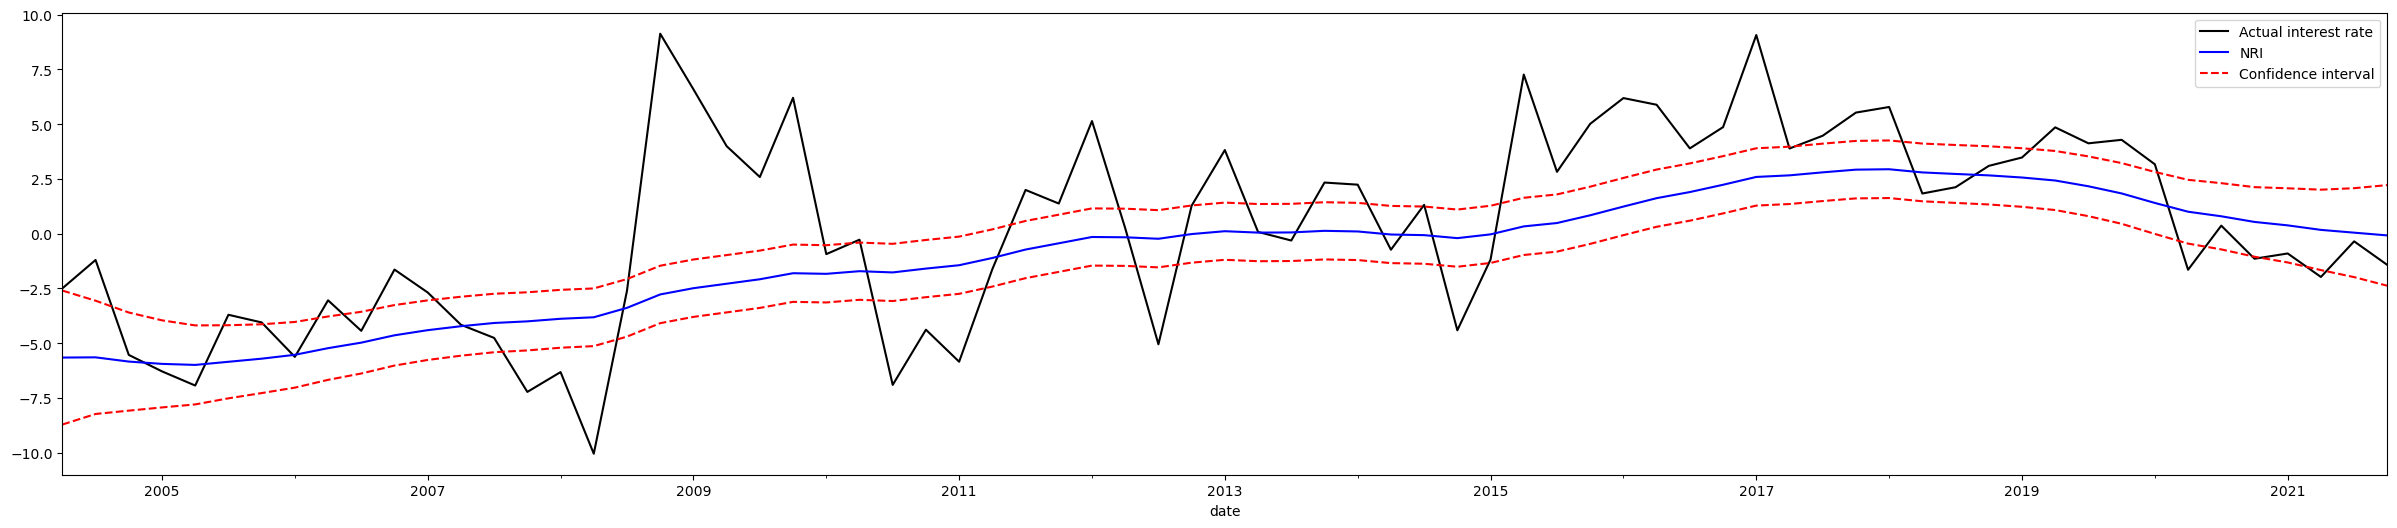

In [9]:
end = data[['dp','y','r']]
exog = data[['oil','cr_to_gdp']]

ggmodel = NRI_Q(end, exog, lambda1=1/20)
res = ggmodel.fit()
print(res.mle_retvals)

display(res.summary())

state_cov = res.states.smoothed_cov.reset_index(level=0)
conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

plt.figure(figsize=(30, 6))
end['r'].plot(color='black', label='Actual interest rate');
res.states.smoothed['state.4'].plot(color='blue', label='NRI');
(res.states.smoothed['state.4']+conf_int).plot(color='red', ls='--', label='Confidence interval');
(res.states.smoothed['state.4']-conf_int).plot(color='red', ls='--', label='_Confidence interval');
plt.legend();

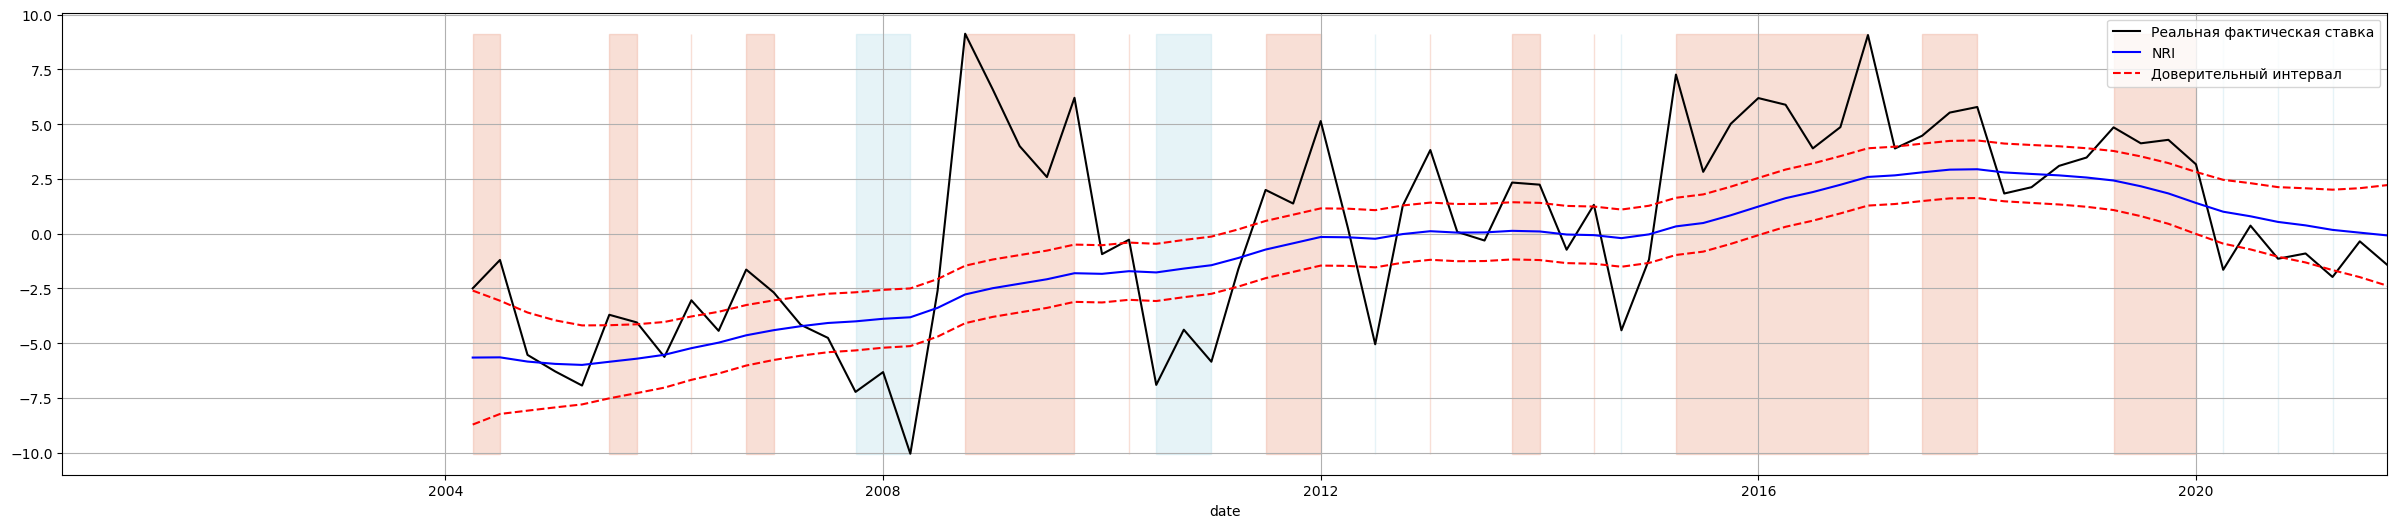

In [11]:
fig, ax = plt.subplots(figsize=(30, 6))
ax.plot(end['r'], color='black', label='Реальная фактическая ставка')
ax.set_xlim([pd.to_datetime('2000-07-01'), pd.to_datetime('2021-10-01')])
ax.plot(res.states.smoothed['state.4'], color='blue', label='NRI')
ax.plot(res.states.smoothed['state.4']+conf_int, color='red', ls='--', label='Доверительный интервал')
ax.plot(res.states.smoothed['state.4']-conf_int, color='red', ls='--', label='_Доверительный интервал')
ax.set(xlabel='date', ylabel='', title='')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']>res.states.smoothed['state.4']+conf_int.values), alpha=0.3, color='darksalmon')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']<res.states.smoothed['state.4']-conf_int.values), alpha=0.3, color='lightblue')
ax.grid();
ax.legend();
plt.show();

In [12]:
# pd.DataFrame(res.summary().tables[1]).to_excel('table2.xlsx')

### Monthly data: adaptive expectations

In [13]:
class NRI_M(sm.tsa.statespace.MLEModel):
    def __init__(self, endog, exog, lambda1=1/10):
        self.k_exog = 1
        exog = np.c_[exog]
                
        super(NRI_M, self).__init__(endog, k_states=6, k_posdef=5, initialization='diffuse', exog=exog)
        self.ssm['design'] = np.array([[1,0,0,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0]])
        self.ssm['transition'] = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[1,1,1,0,0,0],
                                       [0,0,0,1,0,1],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        self.ssm['obs_cov'] = np.zeros((3,3))
        self.ssm['selection', :3, :3] = np.eye(3)
        self.ssm['selection', 4:, 3:] = np.eye(2)
        self.ssm['state_cov'] = np.eye(5)
        self.ssm['state_intercept'] = np.zeros((self.k_states, self.nobs))
#         init = initialization.Initialization(self.k_states)
#         init.set((0, 3), 'stationary')
#         init.set((3, 6), 'diffuse')
#         self.ssm.initialize(init)
        
        self.positive_parameters = slice(7, 10)
        self.stationary_parameters = [2, 6]
        self.lambda1 = lambda1
        self.lambda2 = 1/100
        
    def clone(self, endog, exog=None, **kwargs):
        return self._clone_from_init_kwds(endog, exog=exog, **kwargs)
        
    @property
    def param_names(self):
        return ['a_pp','a_py','b_yy','b_yr','c_rp','c_ry','c_rr',
                's_p','s_y','s_r','d_p','d_y']

    @property
    def start_params(self):
        params = np.r_[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
                       10, 10, 10, -0.1, -0.1]
        return params
        
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.stationary_parameters] = constrain_stationary_univariate(unconstrained[self.stationary_parameters])
        constrained[self.positive_parameters] = unconstrained[self.positive_parameters]**2
        return constrained
    
    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.stationary_parameters] = unconstrain_stationary_univariate(constrained[self.stationary_parameters])
        unconstrained[self.positive_parameters] = constrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)
        self['transition', 0, :2] = params[:2]
        self['transition', 1, 1:3] = params[2:4]
        self['transition', 2, :3] = params[4:7]
        self['state_cov'] = np.diag([params[7]**2, params[8]**2, params[9]**2,
                                     self.lambda1*params[9]**2, self.lambda2*params[8]**2])
#         self['state_intercept'] = ([params[10],params[11],0,0,0,0] * self.exog).T
        self['state_intercept', 0, :] = params[10] * self.exog.T
        self['state_intercept', 1, :] = params[11] * self.exog.T

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'fopt': 5.3204484328010615, 'gopt': array([ 0.02343395,  0.01945282, -0.00091448, -0.00082958,  0.01018803,
       -0.01666151, -0.00129758,  0.00113526,  0.00493689,  0.01879122,
        0.00332138, -0.00125347]), 'fcalls': 832, 'warnflag': 1, 'converged': False, 'iterations': 50}


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       ['dp', 'y', 'r']   No. Observations:                   82
Model:                          NRI_M   Log Likelihood                -436.277
Date:                Wed, 31 May 2023   AIC                            908.554
Time:                        00:59:16   BIC                            951.874
Sample:                    03-01-2015   HQIC                           925.946
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_pp           0.9450      0.018     53.001      0.000       0.910       0.980
a_py           0.0011      0.001      0.990      0.322      -0.001       0.003
b_yy          -0.2455      0.174     -1.409      0.159      -0.587       0.096
b_yr          -0.0740      2.288     -0.032      0.974      -4.558       4.410
c_rp           0.0647      0.059      1.096      0.273      -0.051       0.180
c_ry           0.0117      0.021      0.552      0.581      -0.030       0.053
c_rr           0.6762      0.128      5.288      0.000       0.426       0.927
s_p            0.4940      0.035     14.094      0.000       0.425       0.563
s_y            6.3018      0.434     14.525      0.000       5.451       7.152
s_r            0.7269      0.063     11.587      0.000       0.604       0.850
d_p            0.0035      0.024      0.143      0.886      -0.044       0.051
d_y           -0.0962      6.247     -0.015      0.988     -12.341      12.148
====================================================================================
Ljung-Box (L1) (Q):      43.64, 2.73, 0.62   Jarque-Bera (JB):   87.21, 28.66, 11.44
Prob(Q):                  0.00, 0.10, 0.43   Prob(JB):              0.00, 0.00, 0.00
Heteroskedasticity (H):   0.39, 1.46, 0.89   Skew:               -1.34, -0.82, -0.09
Prob(H) (two-sided):      0.02, 0.33, 0.76   Kurtosis:              7.35, 5.43, 4.84
====================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

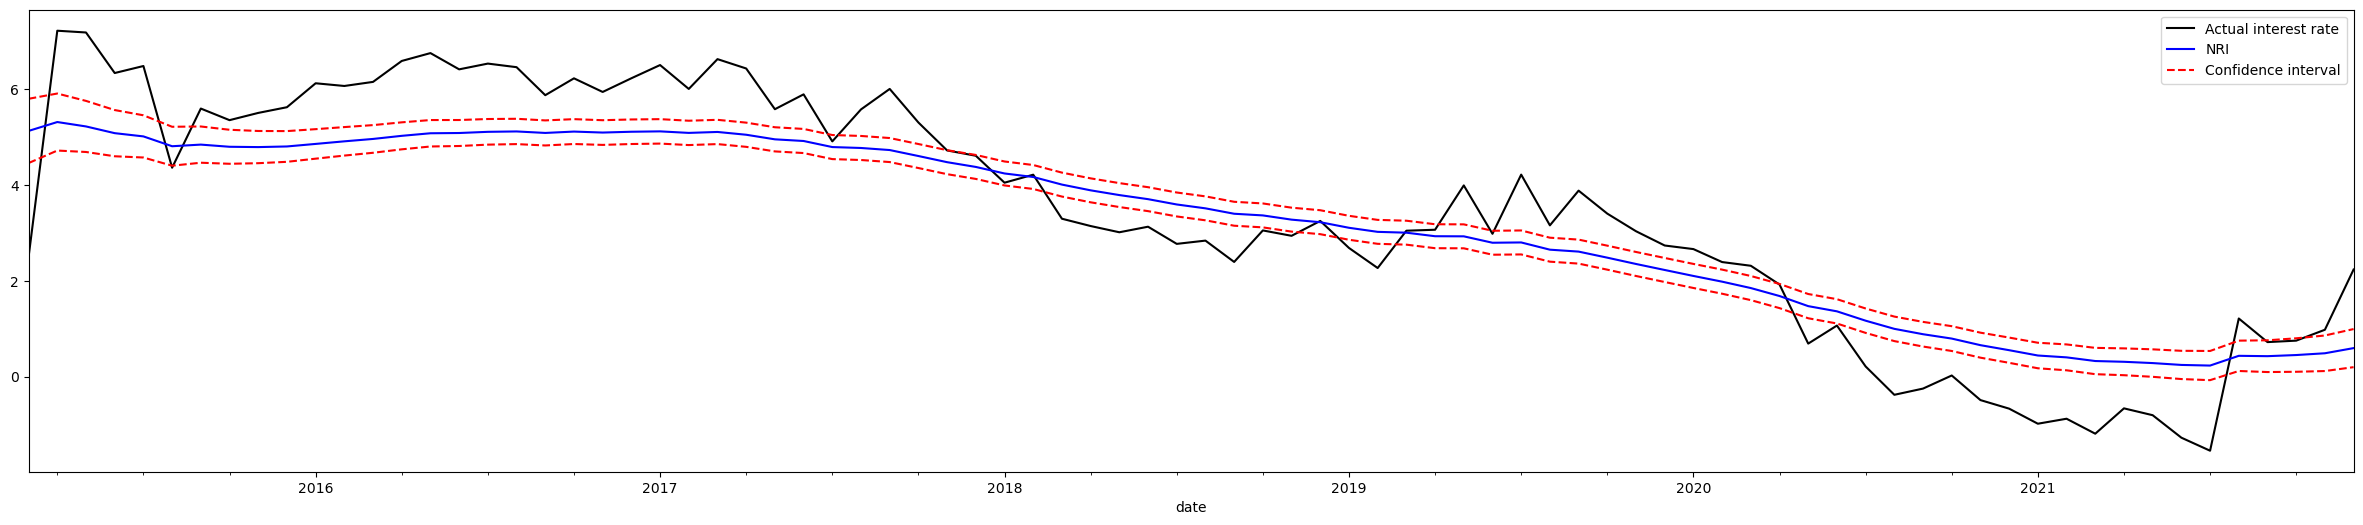

In [14]:
data = pd.read_excel('python_month.xlsx')
data.set_index('date', inplace=True)

data['inf'] = (data.cpi_sa - 100) * 12
data['inf_lag'] = data.inf.shift(1)
data['inf_yoy'] = data.cpi_yoy - 100

data['y'] = data.industry - 100
# data['y'] = data.industry_yoy - 100

data['dp'] = data.inf_yoy - data.target * 100

data['r'] = data.miacr_8d_30d - 0.5 * (data.target * 100 + data.inf_lag)
# data['r'] = data.miacr_8d_30d - data.exp_mom_sa * 12

data['oil'] = np.log(data.brent).shift(1)
data['ex'] = np.log(data.usd).shift(1)
data['inf_exp'] = data.inf.shift(2)
data['inf_cap'] = data.exp_yoy.shift(1) - data.target.shift(1)
data = data.dropna(subset=['y'])
# data = data.dropna(subset=['y','exp_mom_sa'])
data = data.iloc[2:-9,:]

end = data[['dp','y','r']]
exog = data['oil']

ggmodel = NRI_M(end, exog, lambda1=1/10)
res = ggmodel.fit()
print(res.mle_retvals)

display(res.summary())

state_cov = res.states.smoothed_cov.reset_index(level=0)
conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

plt.figure(figsize=(30, 6))
end['r'].plot(color='black', label='Actual interest rate');
res.states.smoothed['state.4'].plot(color='blue', label='NRI');
(res.states.smoothed['state.4']+conf_int).plot(color='red', ls='--', label='Confidence interval');
(res.states.smoothed['state.4']-conf_int).plot(color='red', ls='--', label='_Confidence interval');
plt.legend();

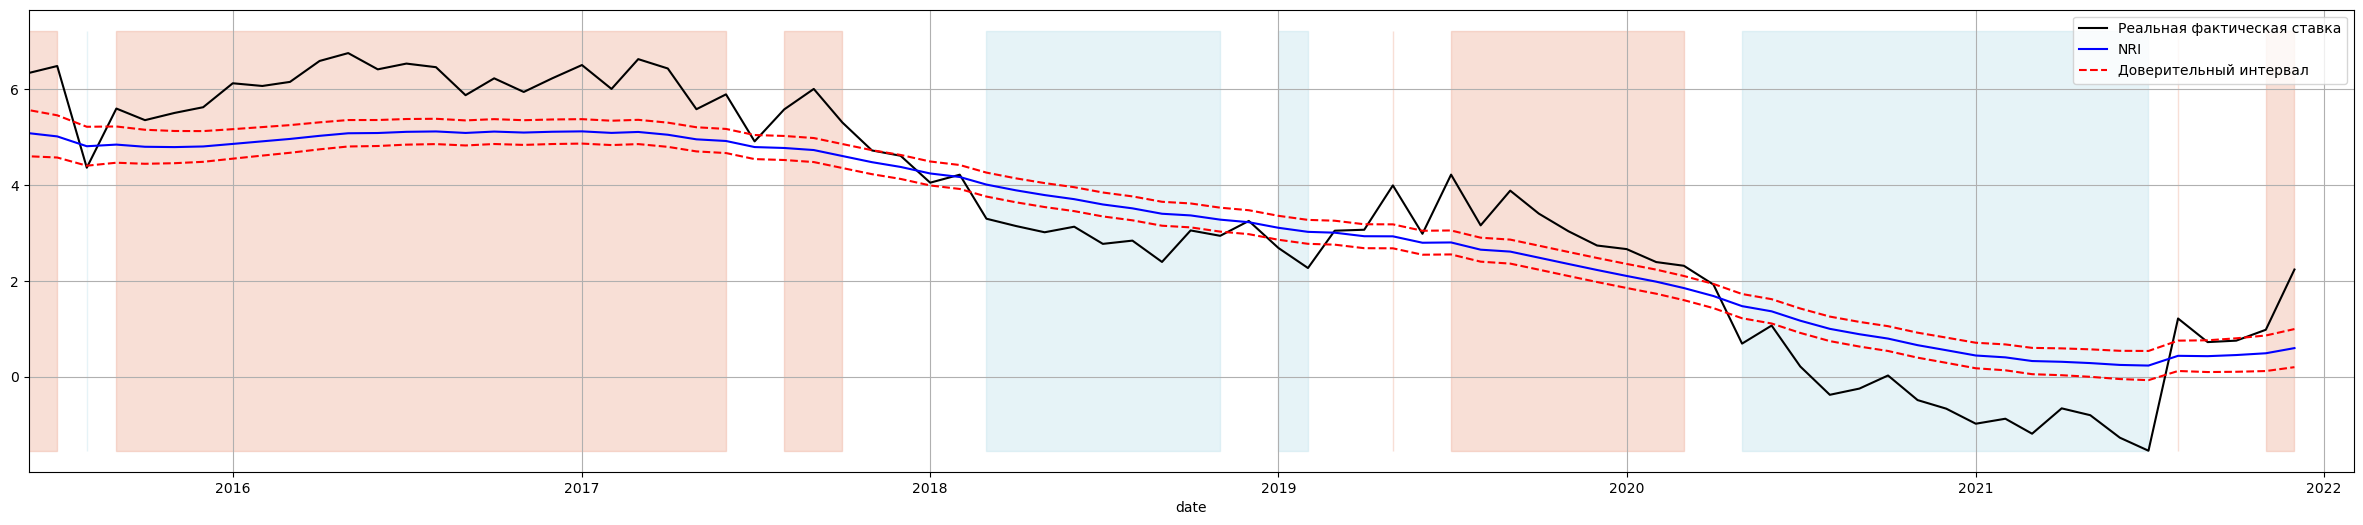

In [16]:
fig, ax = plt.subplots(figsize=(30, 6))
ax.plot(end['r'], color='black', label='Реальная фактическая ставка')
ax.set_xlim([pd.to_datetime('2015-06-01'), pd.to_datetime('2022-02-01')])
ax.plot(res.states.smoothed['state.4'], color='blue', label='NRI')
ax.plot(res.states.smoothed['state.4']+conf_int, color='red', ls='--', label='Доверительный интервал')
ax.plot(res.states.smoothed['state.4']-conf_int, color='red', ls='--', label='_Доверительный интервал')
ax.set(xlabel='date', ylabel='', title='')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']>res.states.smoothed['state.4']+conf_int.values), alpha=0.3, color='darksalmon')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']<res.states.smoothed['state.4']-conf_int.values), alpha=0.3, color='lightblue')
ax.grid();
ax.legend();
plt.show();

In [17]:
# pd.DataFrame(res.summary().tables[1]).to_excel('table3.xlsx')

### Monthly data: rational expectations

C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'fopt': 6.4326531827336915, 'gopt': array([-1.08270267e-02, -3.21873941e-03,  1.24328841e-03, -1.01897326e-03,
       -8.05443889e-04, -2.30848380e-03,  1.03690265e-03, -1.00782875e-03,
        5.48103349e-03, -1.92509120e-05,  2.71946785e-03, -1.69338312e-03]), 'fcalls': 884, 'warnflag': 1, 'converged': False, 'iterations': 50}


C:\Users\Alex\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:       ['dp', 'y', 'r']   No. Observations:                   86
Model:                          NRI_M   Log Likelihood                -553.208
Date:                Wed, 31 May 2023   AIC                           1142.416
Time:                        01:00:10   BIC                           1186.595
Sample:                    01-01-2015   HQIC                          1160.196
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_pp           0.9661      0.023     41.872      0.000       0.921       1.011
a_py          -0.0105      0.006     -1.774      0.076      -0.022       0.001
b_yy          -0.2345      0.187     -1.251      0.211      -0.602       0.133
b_yr          -0.0244      0.587     -0.042      0.967      -1.175       1.126
c_rp           0.0192      0.153      0.125      0.900      -0.281       0.320
c_ry           0.0098      0.050      0.197      0.843      -0.088       0.107
c_rr           0.5460      0.151      3.624      0.000       0.251       0.841
s_p            0.5439      0.054     10.031      0.000       0.438       0.650
s_y            6.7373      0.510     13.222      0.000       5.739       7.736
s_r            1.9425      0.198      9.788      0.000       1.554       2.332
d_p            0.0038      0.063      0.060      0.952      -0.120       0.128
d_y           -0.0978      7.013     -0.014      0.989     -13.842      13.647
======================================================================================
Ljung-Box (L1) (Q):      39.91, 3.68, 0.81   Jarque-Bera (JB):   130.60, 25.74, 567.68
Prob(Q):                  0.00, 0.06, 0.37   Prob(JB):                0.00, 0.00, 0.00
Heteroskedasticity (H):   0.31, 1.24, 0.43   Skew:                  -1.57, -0.47, 2.13
Prob(H) (two-sided):      0.00, 0.57, 0.03   Kurtosis:               8.23, 5.54, 15.00
======================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

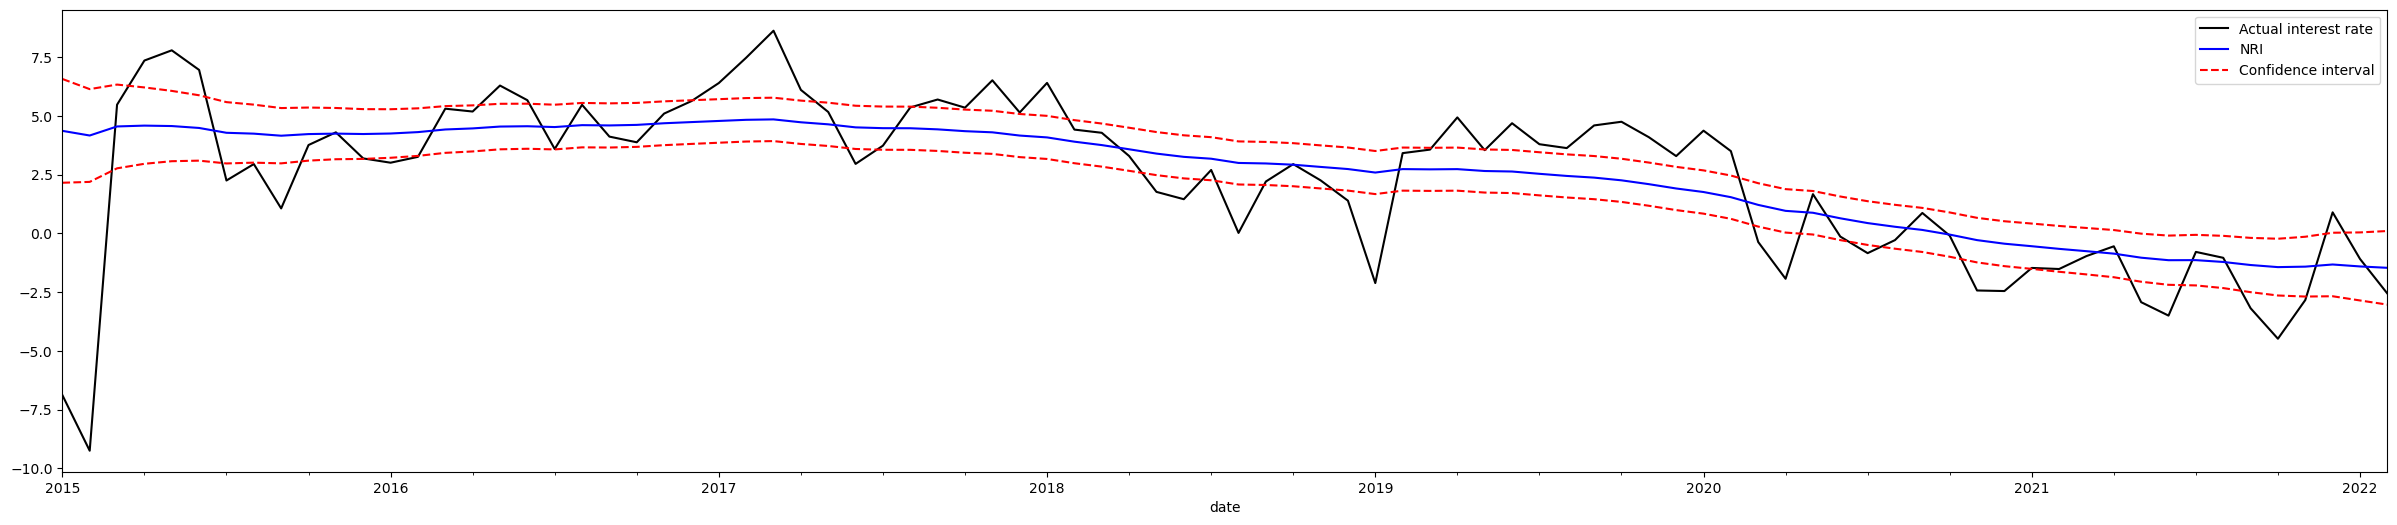

In [18]:
data = pd.read_excel('python_month.xlsx')
data.set_index('date', inplace=True)

data['inf'] = (data.cpi_sa - 100) * 12
data['inf_lag'] = data.inf.shift(1)
data['inf_yoy'] = data.cpi_yoy - 100

data['y'] = data.industry - 100
# data['y'] = data.industry_yoy - 100

data['dp'] = data.inf_yoy - data.target * 100

# data['r'] = data.miacr_8d_30d - 0.5 * (data.target + data.inf_lag)
data['r'] = data.miacr_8d_30d - data.exp_mom_sa * 12

data['oil'] = np.log(data.brent).shift(1)
data['ex'] = np.log(data.usd).shift(1)
data['inf_exp'] = data.inf.shift(2)
data['inf_cap'] = data.exp_yoy.shift(1) - data.target.shift(1)
# data = data.dropna(subset=['y'])
data = data.dropna(subset=['y','exp_mom_sa'])

end = data[['dp','y','r']]
exog = data['oil']

ggmodel = NRI_M(end, exog, lambda1=1/20)
res = ggmodel.fit()
print(res.mle_retvals)

display(res.summary())

state_cov = res.states.smoothed_cov.reset_index(level=0)
conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

plt.figure(figsize=(30, 6))
end['r'].plot(color='black', label='Actual interest rate');
res.states.smoothed['state.4'].plot(color='blue', label='NRI');
(res.states.smoothed['state.4']+conf_int).plot(color='red', ls='--', label='Confidence interval');
(res.states.smoothed['state.4']-conf_int).plot(color='red', ls='--', label='_Confidence interval');
plt.legend();

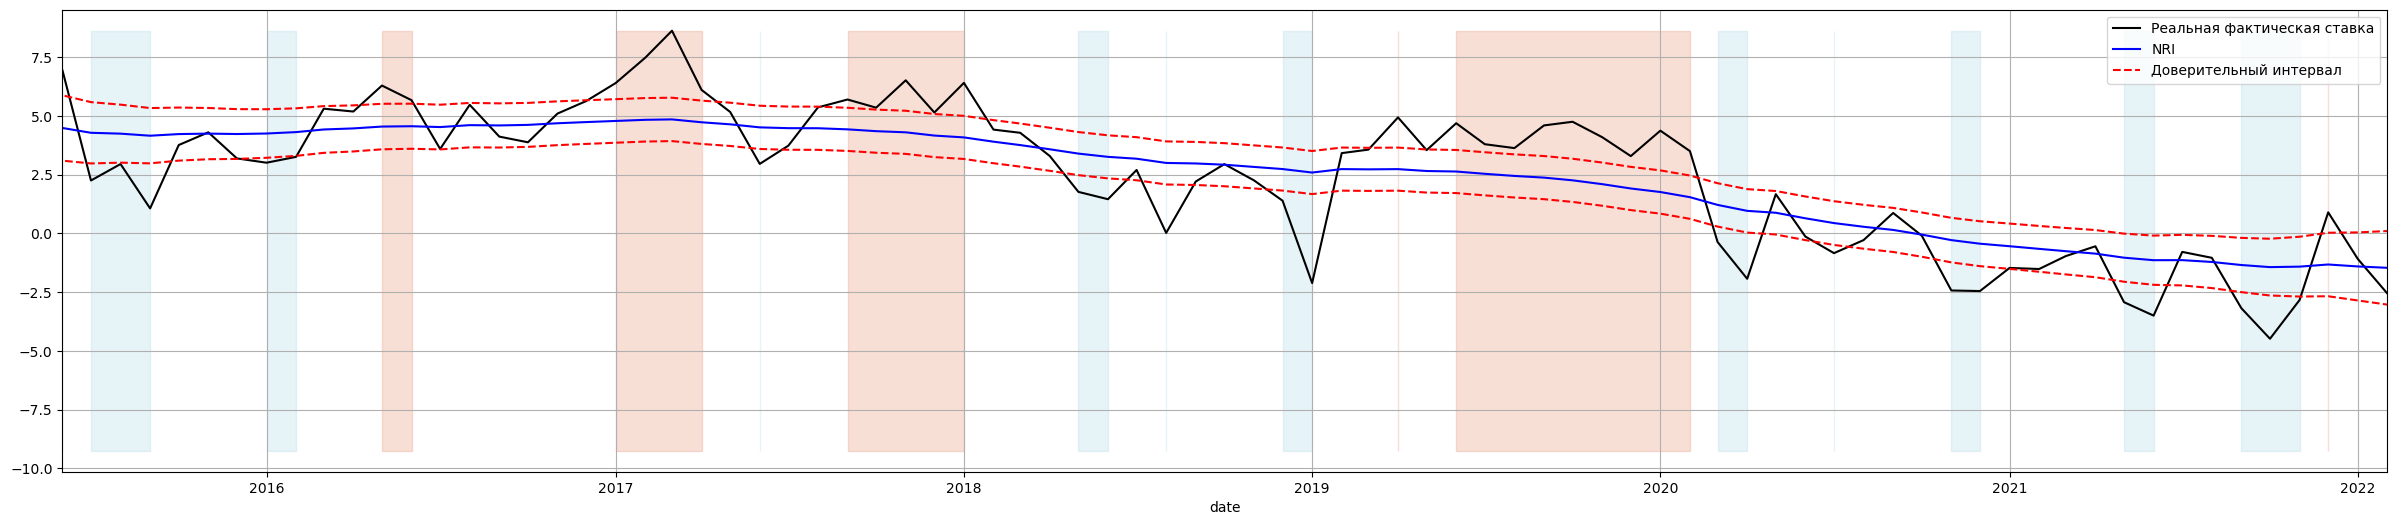

In [20]:
fig, ax = plt.subplots(figsize=(30,6))
ax.plot(end['r'], color='black', label='Реальная фактическая ставка')
ax.set_xlim([pd.to_datetime('2015-06-01'), pd.to_datetime('2022-02-01')])
ax.plot(res.states.smoothed['state.4'], color='blue', label='NRI')
ax.plot(res.states.smoothed['state.4']+conf_int, color='red', ls='--', label='Доверительный интервал')
ax.plot(res.states.smoothed['state.4']-conf_int, color='red', ls='--', label='_Доверительный интервал')
ax.set(xlabel='date', ylabel='', title='')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']>res.states.smoothed['state.4']+conf_int.values), alpha=0.3, color='darksalmon')
ax.fill_between(end['r'].index, end['r'].min(), end['r'].max(),
                where=(end['r']<res.states.smoothed['state.4']-conf_int.values), alpha=0.3, color='lightblue')
ax.grid();
ax.legend();
plt.show();

In [54]:
end

,dp,y,r
date,,,
2015-01-01,10.471464,-17.4,-6.877926
2015-02-01,12.206882,-2.8,-9.245196
2015-03-01,12.426386,10.9,5.469203
2015-04-01,11.916499,-4.7,7.348145
2015-05-01,11.281920,-1.1,7.782826
...,...,...,...
2021-10-01,4.135334,4.8,-4.483070
2021-11-01,4.403766,0.8,-2.836384
2021-12-01,4.393015,13.7,0.893026


In [19]:
# pd.DataFrame(res.summary().tables[1]).to_excel('table4.xlsx')

In [2]:
# class NRI(sm.tsa.statespace.MLEModel):
#     def __init__(self, endog):
        
#         super(NRI, self).__init__(endog, k_states=6, k_posdef=5, initialization='diffuse')
#         self.ssm['design'] = np.array([[1,0,0,0,0,0],[0,1,0,1,0,0],[0,0,1,0,1,0]])
#         self.ssm['transition'] = np.array([[1,1,0,0,0,0],[0,1,1,0,0,0],[1,1,1,0,0,0],
#                                        [0,0,0,1,0,1],[0,0,0,0,1,0],[0,0,0,0,0,1]])
#         self.ssm['obs_cov'] = np.zeros((3,3))
#         self.ssm['selection', :3, :3] = np.eye(3)
#         self.ssm['selection', 4:, 3:] = np.eye(2)
#         self.ssm['state_cov'] = np.eye(5)
# #         init = initialization.Initialization(self.k_states)
# #         init.set((0, 3), 'stationary')
# #         init.set((3, 6), 'diffuse')
# #         self.ssm.initialize(init)
        
#         self.positive_parameters = slice(7, 10)
#         self.stationary_parameters = [0, 2, 6]
#         self.lambda1 = 1/100
#         self.lambda2 = 1/100
        
#     @property
#     def param_names(self):
#         return ['a_pp','a_py','b_yy','b_yr','c_rp','c_ry','c_rr',
#                 's_p','s_y','s_r']

#     @property
#     def start_params(self):
#         params = np.r_[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
#                        10, 10, 10]
#         return params
        
#     def transform_params(self, unconstrained):
#         constrained = unconstrained.copy()
#         constrained[self.stationary_parameters] = constrain_stationary_univariate(unconstrained[self.stationary_parameters])
#         constrained[self.positive_parameters] = unconstrained[self.positive_parameters]**2
#         return constrained
    
#     def untransform_params(self, constrained):
#         unconstrained = constrained.copy()
#         unconstrained[self.stationary_parameters] = unconstrain_stationary_univariate(constrained[self.stationary_parameters])
#         unconstrained[self.positive_parameters] = constrained[self.positive_parameters]**0.5
#         return unconstrained

#     def update(self, params, **kwargs):
#         params = super().update(params, **kwargs)
#         self['transition', 0, :2] = params[:2]
#         self['transition', 1, 1:3] = params[2:4]
#         self['transition', 2, :3] = params[4:7]
#         self['state_cov'] = np.diag([params[7]**2, params[8]**2, params[9]**2,
#                                      self.lambda1*params[9]**2, self.lambda2*params[8]**2])

In [3]:
# end = data[['dp','y','r']]

# ggmodel = NRI(end)
# res = ggmodel.fit()
# res.mle_retvals

# res.summary()

# state_cov = res.states.smoothed_cov.reset_index(level=0)
# conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

# end['r'].plot(color='black');
# res.states.smoothed['state.4'].plot(color='blue');
# (res.states.smoothed['state.4']+conf_int).plot(color='red');
# (res.states.smoothed['state.4']-conf_int).plot(color='red');

In [20]:
# class NRI_T(sm.tsa.statespace.MLEModel):
#     def __init__(self, endog, exog, lambda1=1/50):
#         self.k_exog = 3
#         exog = np.c_[exog]
                
#         super(NRI_T, self).__init__(endog, k_states=6, k_posdef=5, initialization='diffuse', exog=exog)
#         self.ssm['design'] = np.array([[1,0,0,0,0,0],[0,1,0,1,0,0],[0,0,1,0,0,0]])
#         self.ssm['transition'] = np.array([[1,1,0,0,0,0],[0,1,1,0,-1,0],[0,1,1,0,0,0],
#                                        [0,0,0,1,0,1],[0,0,0,0,1,0],[0,0,0,0,0,1]])
#         self.ssm['obs_cov'] = np.zeros((3,3))
#         self.ssm['selection', :3, :3] = np.eye(3)
#         self.ssm['selection', 4:, 3:] = np.eye(2)
#         self.ssm['state_cov'] = np.eye(5)
#         self.ssm['state_intercept'] = np.zeros((self.k_states, self.nobs))
# #         init = initialization.Initialization(self.k_states)
# #         init.set((0, 3), 'stationary')
# #         init.set((3, 6), 'diffuse')
# #         self.ssm.initialize(init)
        
#         self.positive_parameters = slice(7, 10)
#         self.stationary_parameters = [2, 4]
#         self.lambda1 = lambda1
#         self.lambda2 = 1/100
        
#     def clone(self, endog, exog=None, **kwargs):
#         return self._clone_from_init_kwds(endog, exog=exog, **kwargs)
        
#     @property
#     def param_names(self):
#         return ['a_pp','a_py','b_yy','b_yr','g1','g2','g3',
#                 's_p','s_y','s_r','d_po','d_yo']

#     @property
#     def start_params(self):
#         params = np.r_[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
#                        10, 10, 10, -0.1, -0.1]
#         return params
        
#     def transform_params(self, unconstrained):
#         constrained = unconstrained.copy()
#         constrained[self.stationary_parameters] = constrain_stationary_univariate(unconstrained[self.stationary_parameters])
#         constrained[self.positive_parameters] = unconstrained[self.positive_parameters]**2
#         return constrained
    
#     def untransform_params(self, constrained):
#         unconstrained = constrained.copy()
#         unconstrained[self.stationary_parameters] = unconstrain_stationary_univariate(constrained[self.stationary_parameters])
#         unconstrained[self.positive_parameters] = constrained[self.positive_parameters]**0.5
#         return unconstrained

#     def update(self, params, **kwargs):
#         params = super().update(params, **kwargs)
#         self['transition', 0, :2] = params[:2]
#         self['transition', 1, 1:3] = params[2:4]
#         self['transition', 1, 4] = -params[3]
#         self['transition', 2, 1:3] = [(1-params[4])*params[6], params[4]]
#         self['transition', 2, 4] = 1-params[4]
#         self['state_cov'] = np.diag([params[7]**2, params[8]**2, params[9]**2,
#                                      self.lambda1*params[9]**2, self.lambda2*params[8]**2])
        
#         self['state_intercept', 0, :] = params[10] * self.exog.T[0]
#         self['state_intercept', 1, :] = params[11] * self.exog.T[0] - params[3] * self.exog.T[1]
#         self['state_intercept', 2, :] = (1-params[4])*params[5] * self.exog.T[2]

In [21]:
# data = pd.read_excel('python_month.xlsx')
# data.set_index('date', inplace=True)

# data['inf'] = (data.cpi_sa - 100) * 12
# data['inf_lag'] = data.inf.shift(1)
# data['inf_yoy'] = data.cpi_yoy - 100

# data['y'] = data.industry - 100
# # data['y'] = data.industry_yoy - 100

# data['dp'] = data.inf_yoy - data.target * 100

# data['r'] = data.miacr_8d_30d - 0.5 * (data.target * 100 + data.inf_lag)
# # data['r'] = data.miacr_8d_30d - data.exp_mom_sa * 12

# data['oil'] = np.log(data.brent).shift(1)
# data['ex'] = np.log(data.usd).shift(1)
# data['lagged_exp'] = data.inf.shift(2)
# data['inf_cap'] = data.exp_yoy.shift(1) - data.target.shift(1)
# # data = data.dropna(subset=['y'])
# data = data.dropna(subset=['y','exp_yoy'])

# end = data[['dp','y','miacr_8d_30d']]
# exog = data[['oil','lagged_exp','inf_cap']]

# ggmodel = NRI_T(end, exog, lambda1=1/10)

# res = ggmodel.fit()
# # res = ggmodel.fit(preliminary.params, method='nm', disp=0, maxiter=1000)

# res.mle_retvals

# display(res.summary())

# state_cov = res.states.smoothed_cov.reset_index(level=0)
# conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

# data['r'].plot();
# res.states.smoothed['state.4'].plot();
# (res.states.smoothed['state.4']+conf_int).plot();
# (res.states.smoothed['state.4']-conf_int).plot();

In [22]:
# data = pd.read_excel('python_month.xlsx')
# data.set_index('date', inplace=True)

# data['inf'] = (data.cpi_sa - 100) * 12
# data['inf_lag'] = data.inf.shift(1)
# data['inf_yoy'] = data.cpi_yoy - 100

# data['y'] = data.industry - 100
# # data['y'] = data.industry_yoy - 100

# data['dp'] = data.inf_yoy - data.target * 100

# # data['r'] = data.miacr_8d_30d - 0.5 * (data.target + data.inf_lag)
# data['r'] = data.miacr_8d_30d - data.exp_mom_sa * 12

# data['oil'] = np.log(data.brent).shift(1)
# data['ex'] = np.log(data.usd).shift(1)
# data['lagged_exp'] = data.exp_mom_sa.shift(1)
# data['inf_cap'] = data.exp_yoy.shift(1) - data.target.shift(1)
# # data = data.dropna(subset=['y'])
# data = data.dropna(subset=['y','exp_yoy'])

# end = data[['dp','y','miacr_8d_30d']]
# exog = data[['oil','lagged_exp','inf_cap']]

# ggmodel = NRI_T(end, exog, lambda1=1/10)

# res = ggmodel.fit()
# # res = ggmodel.fit(preliminary.params, method='nm', disp=0, maxiter=1000)

# res.mle_retvals

# display(res.summary())

# state_cov = res.states.smoothed_cov.reset_index(level=0)
# conf_int = state_cov[state_cov.level_0=='state.4']['state.4']

# data['r'].plot();
# res.states.smoothed['state.4'].plot();
# (res.states.smoothed['state.4']+conf_int).plot();
# (res.states.smoothed['state.4']-conf_int).plot();